## Config

if the save_path is inside the drive, then you only need to use download_audio_and_extract_spectrograms once. after that you can just reuse the saved spectrograms.

In [1]:
zenodo_recordid= 3819968 # TAU Urban Acoustic Scenes 2020 Mobile, Development dataset
save_path= "/content/drive/MyDrive/dcase/"
download_audio_and_extract_spectrograms=True # do this only once (no need for gpu runtime)

## Dependencies

get the source code form github



In [2]:
import numpy as np
import soundfile as sf
import librosa
from scipy import signal
import os,torch,sys


In [3]:
!git clone https://github.com/kkoutini/cpjku_dcase20

Cloning into 'cpjku_dcase20'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 134 (delta 74), reused 103 (delta 50), pack-reused 0
Receiving objects: 100% (134/134), 469.89 KiB | 24.73 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [4]:
!pip install attrdict
!pip install tensorboardX

In [5]:
sys.path.append(os.path.join(os.getcwd(),"cpjku_dcase20"))
with open(os.path.join(os.getcwd(),"cpjku_dcase20","__init__.py"), "a") as myfile:
      myfile.write("\n")

In [6]:
!ls /content/cpjku_dcase20

audioprocessors.py     figures			README.md
configs		       helpers			runsdir
datasets	       __init__.py		shared_globals.py
datasets.py	       install_dependencies.sh	trainer.py
download_dataset.py    models			utils_funcs.py
eval_pretrained.ipynb  outdir
exp_cp_resnet.py       pretrained_models


In [7]:
print(sys.path)


['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/cpjku_dcase20']


In [8]:
# https://github.com/kkoutini/cpjku_dcase19/blob/master/audioprocessors.py
from audioprocessors import processor_d18 as audio_preprocessor_func # if you're using stereo data use the other processor

Then mount google drive to save the extracted features:


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Get Meta data

In [10]:
import urllib.request, json ,IPython,os
with urllib.request.urlopen(f"https://zenodo.org/api/records/{zenodo_recordid}") as url:
   zenodo_data = json.loads(url.read().decode())
files=zenodo_data['files']
print(zenodo_data['conceptdoi'],zenodo_data['doi'])
print("total files: ",len(files))
IPython.display.HTML(zenodo_data['metadata']['description'])


10.5281/zenodo.3670166 10.5281/zenodo.3819968
total files:  18


In [11]:
metafile=[f['links']['self'] for f in files if "meta" in f['key']][0]
metafile

'https://zenodo.org/api/files/9ca6d852-a480-4d9e-9dda-ba8e419310f7/TAU-urban-acoustic-scenes-2020-mobile-development.meta.zip'

## Download and extract meta files





In [12]:
import requests, zipfile, io
r = requests.get(metafile)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(save_path)
meta_file_path=os.path.join(save_path, [f for f in z.namelist() if "meta" in f][0])
print(meta_file_path)
print(z.namelist())
del z


/content/drive/MyDrive/dcase/TAU-urban-acoustic-scenes-2020-mobile-development/meta.csv
['TAU-urban-acoustic-scenes-2020-mobile-development/meta.csv', 'TAU-urban-acoustic-scenes-2020-mobile-development/evaluation_setup/fold1_train.csv', 'TAU-urban-acoustic-scenes-2020-mobile-development/evaluation_setup/fold1_test.csv', 'TAU-urban-acoustic-scenes-2020-mobile-development/evaluation_setup/fold1_evaluate.csv']


## Download audio files, extract spectrograms and save them to drive
 This can be done only once for the dataset.
This requires about 8GB in google drive, to store the sptrograms.


 make the audio path:




In [13]:
try:
  os.mkdir(meta_file_path.replace("meta.csv","audio"))
except FileExistsError:
  if download_audio_and_extract_spectrograms:
    print(meta_file_path.replace("meta.csv","audio"), " already exist, there is no need to redownload audios")
    print("you can set download_audio_and_extract_spectrograms (in config section) to False")
    raise

/content/drive/MyDrive/dcase/TAU-urban-acoustic-scenes-2020-mobile-development/audio  already exist, there is no need to redownload audios
you can set download_audio_and_extract_spectrograms (in config section) to False


FileExistsError: ignored

In [ ]:
audio_zips=[f['links']['self'] for f in files if "audio" in f['key']]
audio_zips_keys=[f['key'] for f in files if "audio" in f['key']]
print(f"will download {len(audio_zips_keys)} files:",audio_zips_keys)

In [ ]:
skip_files={"add files here if they are already downloaded and extracted."}
#skip_files= set([f for f in audio_zips_keys if ".16." not in f]) # for debuging only use the smallest zip
print(f"will skip {len(skip_files)} files:",skip_files)

In [ ]:
if input("this will download the whole dataset and extract spectrogram, this will take hours continue?")!="y":
  raise KeyboardInterrupt

done_files=[]
if download_audio_and_extract_spectrograms:
  for file_number, (audiozip, audiozip_key) in enumerate(zip(audio_zips,audio_zips_keys)):
    print(f"now working on file #{file_number}/{len(audio_zips_keys)}")
    if audiozip_key in skip_files:
      print(f"skipping {audiozip_key}")
      continue
    with open(os.path.join(save_path,"downloadlog.txt"), "a") as myfile:
      myfile.write("start:"+audiozip_key+"\n")
    !wget $audiozip -O $audiozip_key
    z = zipfile.ZipFile(audiozip_key, 'r')
    with open(os.path.join(save_path,"downloadlog.txt"), "a") as myfile:
      myfile.write("downloaded:"+audiozip_key+"\n")
    print(f"there are {len(z.namelist())} files in {audiozip_key}")
    for clip_num,f in enumerate(z.namelist()):
      print(f"now working on clip #{clip_num}/{len(z.namelist())} in zip #{file_number}")
      wavedata = z.read(f)
      if f[-4:]!=".wav":
        print(f"ignoring non-wave file {f}")
        continue
      spectro=audio_preprocessor_func(io.BytesIO(wavedata)).astype(np.float16) # using float16 to save space on the drive, can be float32 as well
      torch.save(spectro,os.path.join(save_path,f[:-3]+"pt"))
    done_files.append(audiozip_key)
    print(f"Finished: {audiozip_key}")
    os.remove(audiozip_key)
    print(f"Deleted: {audiozip_key}")
    with open(os.path.join(save_path,"downloadlog.txt"), "a") as myfile:
      myfile.write("done:"+audiozip_key+"\n")
else:
  print("will not download any files!")


### Example Spectrogram

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(spectro[0].astype(np.float32))

# Torch Datasets

In [29]:
# todo copy files from drive for speed
#! cp -r /content/drive/MyDrive/dcase/TAU-urban-acoustic-scenes-2020-mobile-development/ /content/


In [14]:
from torch.utils.data import Dataset as TorchDataset
import pandas as pd
from sklearn import preprocessing

class BasicDCASE21Dataset(TorchDataset):
    """
    Basic DCASE20 Dataset

    """

    def __init__(self, meta_csv, selection_file, base_path=None):
      df = pd.read_csv(meta_csv, sep="\t")
      le = preprocessing.LabelEncoder()
      labels = le.fit_transform(df[['scene_label']].values.reshape(-1))
      self.files = df[['filename']].values.reshape(-1)
      self.labels = labels
      self.df = df
      self.le =le
      self.base_path = base_path
      if self.base_path is None:
        self.base_path = meta_csv.replace("meta.csv","")
      # read the train/test files list
      selectiondf = pd.read_csv(selection_file,sep="\t")
      self.selected_indices = [i for i,f in enumerate(self.files) 
            if f in set(selectiondf['filename'].values.reshape(-1))]
      
    def __getitem__(self, index):
      i=self.selected_indices[index]
      f= self.files[i]
      a=torch.load(self.base_path+f.replace(".wav",".pt"))
      return a, f, self.labels[i],

    def __len__(self):
      return len(self.selected_indices)

trainingset=BasicDCASE21Dataset(meta_file_path,
                                meta_file_path.replace("meta.csv","evaluation_setup/fold1_train.csv")  )
testset=BasicDCASE21Dataset(meta_file_path,
                                meta_file_path.replace("meta.csv","evaluation_setup/fold1_test.csv")  )

In [15]:
len(trainingset),len(testset)

(13962, 2968)

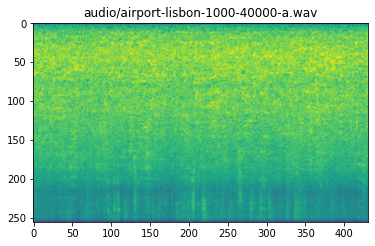

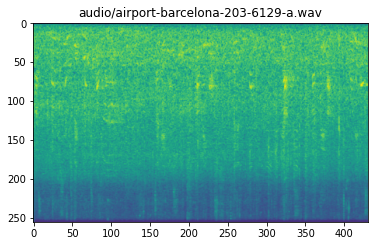

In [16]:
import matplotlib.pyplot as plt
spectro,name,label = trainingset[0] # this some times get's stuck, please be patient and then try to interrupt
plt.imshow(spectro[0].astype(np.float32))
plt.title(name)
plt.show()
spectro,name,label = testset[0]
plt.imshow(spectro[0].astype(np.float32))
plt.title(name)
plt.show()


# Training

## Setup


In [17]:
import argparse
import datetime
import os
import shutil
import time
import random
import json

from trainer import Trainer
import utils_funcs
import traceback
import importlib
available_models = [m[:-3] for m  in os.listdir("cpjku_dcase20/models") if m.startswith("cp_")]
print("available models:",", ".join(available_models))

with open("cpjku_dcase20/configs/cp_resnet.json", "r") as text_file:
  default_conf = json.load(text_file)




available models: cp_resnet_freqdamp_old_challenge, cp_faresnet, cp_resnet_freq_damp, cp_resnet_decomp_freq_damp, cp_resnet, cp_resnet_df_prune, cp_resnet_dampfr_gate_prune, cp_resnet_decomp, cp_resnet_prune


## Config

In [18]:
from attrdict import AttrDefault
args=  AttrDefault(lambda: None)

args.epochs = 250 # number of epochs to train
args.mixup = True # use mixup augementations
args.num_of_classes = 10 # number of output classes in the model

args.audio_input_channels = 1 # use 2 for stereo (need to use a different spectrograms)

args.lr = 0.0001 # learning rate

args.arch = "cp_resnet" # The CNN architecture, one from the files located in `models/` available_models
assert args.arch in available_models

args.rho = 5 #'rho value as explained in DCASE2019 workshop paper '
             # '"Receptive-Field-Regularized CNN Variants for Acoustic Scene Classification"'
             #  '# rho value control the MAX RF of the Network values from 5-9 corresponds max rf similar to the popular VGG-like nets.'


# Parameter Reduction options:
#  CP-ResNet inital width.
args.width = 128 # 'Width determines the initial number of channels.'
                 #       'increasing the width may improve the performance but at the cost of efficiency.'

# Removes tailing 1x1 layers from CP-ResNet to save parameters, make sure that no 3x3 layers are removed otherwise the Receptive Field of the network will will change.
args.depth_restriction = "0,0,0" #The number of tailing layers to be removed from each of the three stages. A string contains 3 integers separated by commmas.

# only for decomp networks

args.decomp_factor= 4 # decomposition factor (Z in the paper), used for all decomposed convolution layers. Needs the args.arch to be cp_resnet_decomp or cp_resnet_decomp_freq_damp.\
                      # if the architecture is not decomposed, this argument will be silently ignored.'


# only for pruned networks

# http://dcase.community/documents/workshop2020/proceedings/DCASE2020Workshop_Koutini_91.pdf
args.prunning_mode=False #if true, run the training in pruning mode. requires an architecture that supports pruning.\
      # for example: cp_resnet_prune or cp_resnet_df_prune.

args.prune_rampup="exponential" # or "linear"
                     #The function describing number of pruned parameters each epochs, linear or exponential. See DCASE20 Workshop paper for details `\
                     # Low-Complexity Models for Acoustic Scene Classification Based on Receptive Field Regularization and Frequency Damping`.  
assert args.prune_rampup in ["exponential","linear"]
args.prune_rampup_len=50 # Number of epochs until the number of pruned parameters reaches the final required number.
args.prune_ratio = -1 #The ratio of parameters to be pruned. for example 0.9 means 90\% of parameters will be pruned.\
                     # if set to `-1` then the percentage will be calculate based on the arg `prune_target_params`.
args.prune_target_params = -1 # The number of parameters to remain after pruning. `prune_ratio` have to be `-1` otherwise this argument will be ignored.'

args.prune_method = "all" # or "layer"
                    #'Indicates wether to select the parameters to be pruned per layer or globally from all the network parameters. \
                    # Pruning per layer is more robust agaisnt layers collapsing.
assert args.prune_method  in ["all","layer"]

args.outdir=save_path # where to save run results, default to google drive

## Pretraining setup and summery

In [19]:

default_conf['out_dir'] = save_path+args.arch+"/"+ str(datetime.datetime.now().strftime('%b%d_%H.%M.%S'))+"/"

print("The experiment outputs will be found at: ", default_conf['out_dir'])
tensorboard_write_path = default_conf['out_dir'].replace("out", "runs", 1)
print("The experiment tesnorboard can be accessed: tensorboard --logdir  ", tensorboard_write_path)

print("Rho value : ", args.rho)
print("Use Mix-up : ", args.mixup)
arch = importlib.import_module('models.{}'.format(args.arch))
model_config_overrides = {"base_channels": args.width, "n_blocks_per_stage": [4-int(b) for b in args.depth_restriction.split(",")],
                          "decomp_factor": args.decomp_factor,
                          "n_classes":  args.num_of_classes, 
                          }
# pruning mode
if args.prunning_mode:
    default_conf['prune_mode']= args.prune_method
    default_conf['adaptive_prune_rampup_mode']=args.prune_rampup
    default_conf['adaptive_prune_rampup_len']=args.prune_rampup_len
    default_conf['prune_percentage']=args.prune_ratio
    default_conf['prune_percentage_target_params']=args.prune_target_params
    if args.prune_ratio!=-1 and  args.prune_ratio>1.:
        raise RuntimeError("prune_ratio should be -1 (then it will be calculated from prune_target_params) or between 0 and 1.")
    if args.prune_ratio==-1 and args.prune_target_params==-1:
        raise RuntimeError("prune_ratio or prune_target_params need to be set.")

# get the final architecture config
default_conf['model_config'] = arch.get_model_based_on_rho(args.rho, args.arch, config_only=True, model_config_overrides=model_config_overrides)

# find the RF at the 24th layer of the model defined by this config
# this equations are explained in:
# The Receptive Field as a Regularizer in Deep Convolutional Neural Networks for Acoustic Scene Classification,
try:
    # set utils_funcs.model_config to the current model (not safe with lru)
    utils_funcs.model_config = default_conf['model_config']
    utils_funcs.get_maxrf.cache_clear()
    _, max_rf = utils_funcs.get_maxrf(24)
    print("For this Rho, the maximium RF is: ", max_rf)
except:
    print("couldn't determine the max RF, maybe non-standard model_config")
    traceback.print_exc()

if args.mixup:
    default_conf['use_mixup'] = True
    default_conf['loss_criterion'] = 'mixup_default'
else:
    default_conf['use_mixup'] = False

default_conf['model_config']['input_shape'][1]= args.audio_input_channels

default_conf['optim_config']['base_lr']=args.lr
default_conf['optim_config']['scheduler_args']['lr_init']=args.lr

# we are using the manual datasets
default_conf['audiodataset'] = {}
default_conf['datasets'] = {}


The experiment outputs will be found at:  /content/drive/MyDrive/dcase/cp_resnet/Apr12_13.34.19/
The experiment tesnorboard can be accessed: tensorboard --logdir   /content/drive/MyDrive/dcase/cp_resnet/Apr12_13.34.19/
Rho value :  5
Use Mix-up :  True
For this Rho, the maximium RF is:  81


In [20]:
! nvidia-smi

Mon Apr 12 13:34:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
trainer = Trainer(default_conf)


0.0
Network(
  (in_c): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (stage1): Sequential(
    (block1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (maxpool1_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block2): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [22]:
from helpers.utils import count_parameters,worker_init_fn,swa_moving_average,bn_update
print("Trainable model parameters {}, non-trainable {} ".format(
            count_parameters(trainer.bare_model), count_parameters(trainer.bare_model, False)))


Trainable model parameters 3563412, non-trainable 0 


### Add dataloaders

In [23]:
from torch.utils.data import DataLoader, RandomSampler

trainer.data_loaders["train"] = DataLoader(worker_init_fn=worker_init_fn, batch_size=20,
                          num_workers=2, shuffle=True, dataset=trainingset)
trainer.data_loaders["testing"] = DataLoader(worker_init_fn=worker_init_fn, batch_size=20,
                          num_workers=2, shuffle=False, dataset=testset)
trainer.colab_mode=True
class ClassHolder:
  pass
dsconf = ClassHolder()
dsconf.__setattr__("_mapping",{})

# Main Training loop

In [ ]:
all_testing_results=[]
for epoch in range(args.epochs):
    # Training
    if trainer.prune_mode:
        trainer.model.set_prune_flag(True)
        ramp_up_function = None
        if trainer.config.adaptive_prune_rampup_mode == "linear":
            ramp_up_function = linear_rampup
        if trainer.config.adaptive_prune_rampup_mode == "exponential":
            ramp_up_function = customsigmoid_rampup
        remaining_params = trainer.model.update_prune_weights(trainer.real_prune_percentage *
                                                            ramp_up_function(epoch,
                                                                            trainer.config.adaptive_prune_rampup_len),
                                                            trainer.config.prune_mode)
        trainer.writer.add_scalar("remaining_params", remaining_params, epoch)
        print("remaining_params (epoch %d): %d" % (epoch, remaining_params))


    trainer.train(epoch, "train", dsconf)
    # notify the model that training done
    epoch_done_op = getattr(trainer.bare_model, "epoch_done", None)
    if callable(epoch_done_op):
        epoch_done_op(epoch)

    # Testing
    testing_result = {}

    testing_result["testing"] = trainer.test(epoch, "testing", dsconf)
    all_testing_results.append(testing_result)
    # updating the state with new results
    trainer.update_state(testing_result, epoch)

    #trainer.run.info['epoch'] = epoch
    trainer.eventAfterEpoch(trainer, epoch)

